# Testing the SolFinder python library


This Notebook illustrates the use of the SolFinder python library to select Pareto optimal solutions using different multi-criteria decision-making strategies. 
The main goals of this notebook are the following:

1. understand which optimal **solution(s) is(are) selected** among the Pareto-optimal solutions using each method.
2. explore how the different methods are suitable for the identification of **eco-efficient aircraft trajectories**.
3. decide which strategy to implement in the fortran version of SolFinder, coupled with the AirTraf submodel.

Copyright 2023 Federica Castino 

Licensed under GNU LGPL-3.0-or-later 

### Table of content:
- [Packages](#Packages)
- [Application of selected multi-criteria decision-making methods](#Application-of-selected-multi-criteria-decision-making-methods)
    - [GRA (= Gray Relational Analysis)](#GRA-(=-Gray-Relational-Analysis))
    - [TOPSIS (= Technique for Order of Preference by Similarity to Ideal Solution)](#TOPSIS-(=-Technique-for-Order-of-Preference-by-Similarity-to-Ideal-Solution))
    - [VIKOR (= Viekriterijumsko Kompromisno Rangiranje)](#VIKOR-(=-Viekriterijumsko-Kompromisno-Rangiranje))
- [Comparing GRA, TOPSIS, and VIKOR results](#Comparing-GRA,-TOPSIS,-and-VIKOR-results)
- [Test implementation Python package](#Test-implementation-Python-package)

***

**Bibliography:**

- *Castino et al. (2023), *Decision-Making strategies implemented in SolFinder 1.0 to identify eco-efficient aircraft trajectories: application study in AirTraf 3.0*, submitted to GMDD, 2023.*
- *Wang, Z., & Rangaiah, G. P. (2017). Application and Analysis of Methods for Selecting an Optimal Solution from the Pareto-Optimal Front obtained by Multiobjective Optimization. Industrial and Engineering Chemistry Research, 56(2), 560–574. https://doi.org/10.1021/acs.iecr.6b03453*
- *Kou, G., Lu, Y., Peng, Y., and Shi, Y.: Evaluation of classification algorithms using MCDM and rank correlation, International Journal of Information Technology and Decision Making, 11, 197–225, https://doi.org/10.1142/S0219622012500095, 2012.*
- *Opricovic, S. and Tzeng, G.-H.: Compromise solution by MCDM methods: A comparative analysis of VIKOR and TOPSIS, European Journal of Operational Research, 156, 445–455, https://doi.org/10.1016/S0377-2217(03)00020-1, 2004.* 
- *Pasman, H. J., Rogers, W. J., and Behie, S. W.: Selecting a method/tool for risk-based decision making in complex situations, Journal of Loss Prevention in the Process Industries, 74, https://doi.org/10.1016/j.jlp.2021.104669, 2022.*
- *Sałabun, W., Wa¸tróbski, J., and Shekhovtsov, A.: Are MCDA Methods Benchmarkable? A Comparative Study of TOPSIS, VIKOR, COPRAS, and PROMETHEE II Methods, Symmetry, 12, 1549, https://doi.org/10.3390/sym12*

<hr style="border:2px solid gray"> </hr>


# Packages 

In [1]:
#pip install solfinder

In [2]:
#pip install solfinder --upgrade

In [3]:
pip show solfinder

Name: solfinder
Version: 1.0.4
Summary: SolFinder 1.0.4
Home-page: UNKNOWN
Author: fcastino
Author-email: f.castino@tudelft.nl
License: GNU LGPLv3
Location: c:\programs\anaconda3\lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [21]:
#%% Imort packages and set general settings

import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
xr.set_options(display_style="html")

import solfinder.MCDM as mcdm


# Application of selected multi-criteria decision-making methods

In [5]:
# Dataset to Test Python SolFinder (tps) version 

fnames_tps = glob.glob('./Data_SolFinder_GMDD_4TU/biobj_atr_soc_1day/POBJ_*.dat')
fnames_tps.sort()
data_tps = [np. loadtxt(f, unpack = True) for f in fnames_tps]
print('Number of Pareto fronts:', len(data_tps))

Number of Pareto fronts: 100


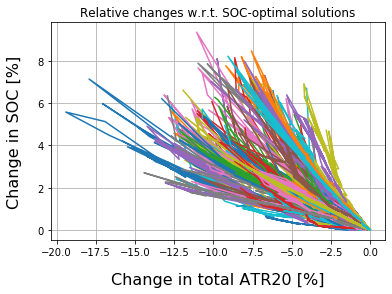

In [6]:
# Overview of 100 Pareto fronts

for citypair in range(len(data_tps)):
    
    atr = data_tps[citypair][1]
    soc = data_tps[citypair][0]
    
    pc_atr = 100*(atr-atr.max())/atr.max()
    pc_soc = 100*(soc-soc.min())/soc.min()

    plt.plot(pc_atr, pc_soc)
    plt.xlabel(r'Change in total ATR20 [%]', fontsize=16, labelpad=15)
    plt.ylabel(r'Change in SOC [%]', fontsize=16, labelpad=15)
    plt.title('Relative changes w.r.t. SOC-optimal solutions')
    plt.grid(True)


plt.show()


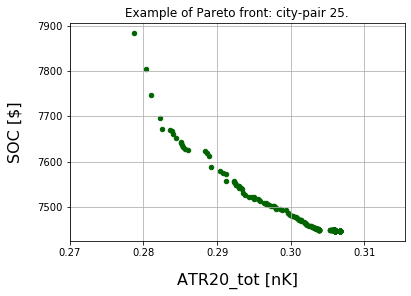

In [7]:
# Shape of one Pareto front, taken as example

citypair = 25
plt.scatter(1e9*data_tps[citypair][1], data_tps[citypair][0], s=20, c='darkgreen')
plt.xlabel(r'ATR20_tot [nK]', fontsize=16, labelpad=15)
plt.ylabel(r'SOC [$]', fontsize=16, labelpad=15)
plt.title('Example of Pareto front: city-pair {}.'.format(citypair))
plt.grid(True)
plt.show()

## GRA (= Gray Relational Analysis)

The main advantage and peculiarity of this mehtod is that it does NOT require any inputs (including weightage).


In [8]:
ATR20_solution_found_with_gra = np.empty(len(data_tps), dtype=object)
SOC___solution_found_with_gra = np.empty(len(data_tps), dtype=object)
ATR20_soc_optimal = np.empty(len(data_tps), dtype=object)
SOC___soc_optimal = np.empty(len(data_tps), dtype=object)
coeff_k_found_with_gra = np.empty(len(data_tps), dtype=object)

for citypair in range(len(data_tps)):
    
    solution_found_with_gra = mcdm.GRA.solution_found_by_gra(mcdm.GRA(), data_tps[citypair])
    ATR20_solution_found_with_gra[citypair] = data_tps[citypair][1][solution_found_with_gra]
    SOC___solution_found_with_gra[citypair] = data_tps[citypair][0][solution_found_with_gra]

    ATR20_soc_optimal[citypair] = max(data_tps[citypair][1])
    SOC___soc_optimal[citypair] = min(data_tps[citypair][0])
    
    coeff_k_found_with_gra[citypair] = (SOC___solution_found_with_gra[citypair]-SOC___soc_optimal[citypair])/(ATR20_soc_optimal[citypair]-ATR20_solution_found_with_gra[citypair]) 
    
    plt.scatter(1e9*data_tps[citypair][1], data_tps[citypair][0], s=20, c='darkgreen')
    plt.scatter(1e9*data_tps[citypair][1][solution_found_with_gra], data_tps[citypair][0][solution_found_with_gra], s=50, c='red')
    plt.xlabel(r'ATR20_tot [nK]', fontsize=16, labelpad=15)
    plt.ylabel(r'SOC [$]', fontsize=16, labelpad=15)
    plt.grid(True)
    plt.savefig('./Figures/solutions_found_with_gra/solution_found_with_gra_cp_{0:02d}.png'.format(citypair), bbox_inches='tight')
    plt.close()

## TOPSIS (= Technique for Order of Preference by Similarity to Ideal Solution)

This method uses the Euclidean distances from the positive and negative ideal solutions to determine the preferred optimal solution.

In [9]:
# User input
w = [0.5, 0.5]

In [10]:
ATR20_solution_found_with_topsis = np.empty(len(data_tps), dtype=object)
SOC___solution_found_with_topsis = np.empty(len(data_tps), dtype=object)
ATR20_soc_optimal = np.empty(len(data_tps), dtype=object)
SOC___soc_optimal = np.empty(len(data_tps), dtype=object)
coeff_k_found_with_topsis = np.empty(len(data_tps), dtype=object)

for citypair in range(len(data_tps)):
    
    solution_found_with_topsis = mcdm.TOPSIS.solution_found_by_topsis(mcdm.TOPSIS(), data_tps[citypair], w)
    ATR20_solution_found_with_topsis[citypair] = data_tps[citypair][1][solution_found_with_topsis]
    SOC___solution_found_with_topsis[citypair] = data_tps[citypair][0][solution_found_with_topsis]

    ATR20_soc_optimal[citypair] = max(data_tps[citypair][1])
    SOC___soc_optimal[citypair] = min(data_tps[citypair][0])
    
    coeff_k_found_with_topsis[citypair] = (SOC___solution_found_with_topsis[citypair]-SOC___soc_optimal[citypair])/(ATR20_soc_optimal[citypair]-ATR20_solution_found_with_topsis[citypair]) 
    
    plt.scatter(1e9*data_tps[citypair][1], data_tps[citypair][0], s=20, c='darkgreen')
    plt.scatter(1e9*data_tps[citypair][1][solution_found_with_topsis], data_tps[citypair][0][solution_found_with_topsis], s=50, c='red')
    plt.xlabel(r'ATR20_tot [nK]', fontsize=16, labelpad=15)
    plt.ylabel(r'SOC [$]', fontsize=16, labelpad=15)
    plt.grid(True)
    plt.savefig('./Figures/solutions_found_with_topsis/solution_found_with_topsis_cp_{0:02d}.png'.format(citypair), bbox_inches='tight')
    plt.close()

## VIKOR (= Viekriterijumsko Kompromisno Rangiranje)



In [11]:
# Input: weights and parameter gamma
w = [0.5, 0.5]
gamma = 0.5 # weight of maximum group utility

In [12]:
ATR20_solution_found_with_vikor = np.empty(len(data_tps), dtype=object)
SOC___solution_found_with_vikor = np.empty(len(data_tps), dtype=object)
ATR20_soc_optimal = np.empty(len(data_tps), dtype=object)
SOC___soc_optimal = np.empty(len(data_tps), dtype=object)
coeff_k_found_with_vikor = np.empty(len(data_tps), dtype=object)

for citypair in range(len(data_tps)):
    
    set_solutions_found_with_vikor, solution_found_with_vikor  = mcdm.VIKOR.solution_found_by_vikor(mcdm.VIKOR(), data_tps[citypair], gamma, w)
    ATR20_solution_found_with_vikor[citypair] =data_tps[citypair][1][solution_found_with_vikor]
    SOC___solution_found_with_vikor[citypair] =data_tps[citypair][0][solution_found_with_vikor]
    
    ATR20_soc_optimal[citypair] = max(data_tps[citypair][1])
    SOC___soc_optimal[citypair] = min(data_tps[citypair][0])
    
    coeff_k_found_with_vikor[citypair] = (SOC___solution_found_with_vikor[citypair]-SOC___soc_optimal[citypair])/(ATR20_soc_optimal[citypair]-ATR20_solution_found_with_vikor[citypair]) 
    
    plt.scatter(1e9*data_tps[citypair][1], data_tps[citypair][0], s=20, c='darkgreen')
    plt.scatter(1e9*ATR20_solution_found_with_vikor[citypair], SOC___solution_found_with_vikor[citypair], s=50, c='red')
    plt.xlabel(r'ATR20_tot [nK]', fontsize=16, labelpad=15)
    plt.ylabel(r'SOC [$]', fontsize=16, labelpad=15)
    plt.grid(True)
    plt.savefig('./Figures/solutions_found_with_vikor/solution_found_with_vikor_cp_{0:02d}.png'.format(citypair), bbox_inches='tight')
    plt.close()

13 : this is the only recommended solution
stable solution -> this is the only recommended solution
19 : this is the only recommended solution
6 : this is the only recommended solution
33 : this is the only recommended solution
13 : this is the only recommended solution
stable solution -> this is the only recommended solution
12 : this is the only recommended solution
6 : this is the only recommended solution
7 : this is the only recommended solution
12 : this is the only recommended solution
13 : this is the only recommended solution
stable solution -> this is the only recommended solution
8 : this is the only recommended solution
12 : this is the only recommended solution
15 : this is the only recommended solution
10 : this is the only recommended solution
13 : this is the only recommended solution
10 : this is the only recommended solution
15 : this is the only recommended solution
8 : this is the only recommended solution
26 : this is the only recommended solution
22 : this is the 

# Comparing GRA, TOPSIS, and VIKOR results

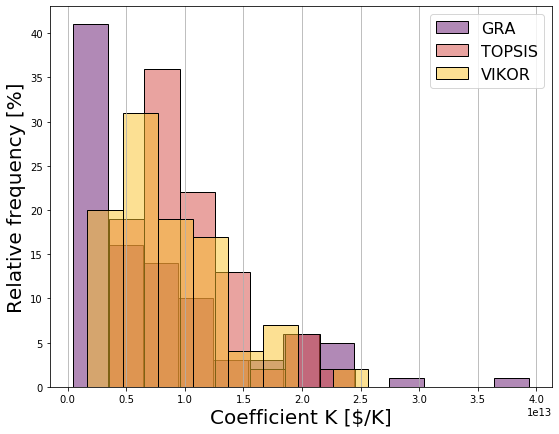

In [13]:
my_stat='percent'
palette = sns.color_palette("inferno")

fig, ax0 = plt.subplots(figsize=(9,7))

line1 = sns.histplot(coeff_k_found_with_gra,     color=palette[1], alpha=0.5, stat=my_stat, binwidth=3e12, label='GRA')
line2 = sns.histplot(coeff_k_found_with_topsis,  color=palette[3], alpha=0.5, stat=my_stat, binwidth=3e12, label='TOPSIS')
line3 = sns.histplot(coeff_k_found_with_vikor,   color=palette[5], alpha=0.5, stat=my_stat, binwidth=3e12, label='VIKOR')   

plt.xlabel(r'Coefficient K [$/K]', fontsize=20)
plt.ylabel('Relative frequency [%]', fontsize=20)

plt.gca().xaxis.grid(True)
plt.legend(prop={'size': 16}, ncol=1)
plt.show()

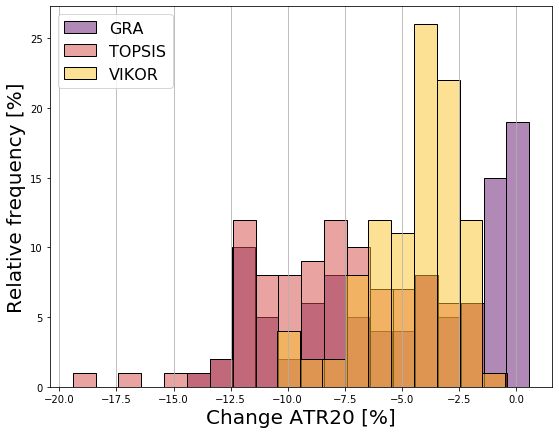

In [14]:
my_stat='percent'
palette = sns.color_palette("inferno")

fig, ax0 = plt.subplots(figsize=(9,7))

line1 = sns.histplot(100*(ATR20_solution_found_with_gra - ATR20_soc_optimal)/ATR20_soc_optimal,     color=palette[1], alpha=0.5, stat=my_stat, binwidth=1, label='GRA')
line2 = sns.histplot(100*(ATR20_solution_found_with_topsis - ATR20_soc_optimal)/ATR20_soc_optimal,  color=palette[3], alpha=0.5, stat=my_stat, binwidth=1, label='TOPSIS')
line3 = sns.histplot(100*(ATR20_solution_found_with_vikor - ATR20_soc_optimal)/ATR20_soc_optimal,   color=palette[5], alpha=0.5, stat=my_stat, binwidth=1, label='VIKOR')   

plt.xlabel(r'Change ATR20 [%]', fontsize=20)
plt.ylabel('Relative frequency [%]', fontsize=20)

plt.gca().xaxis.grid(True)
plt.legend(prop={'size': 16}, ncol=1)
plt.show()

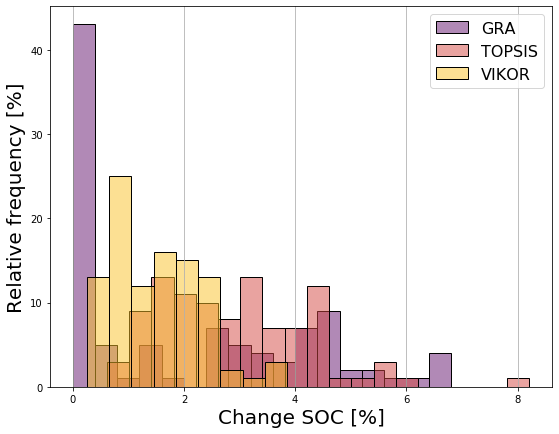

In [15]:
my_stat='percent'
palette = sns.color_palette("inferno")

fig, ax0 = plt.subplots(figsize=(9,7))

line1 = sns.histplot(100*(SOC___solution_found_with_gra - SOC___soc_optimal)/SOC___soc_optimal,    color=palette[1], alpha=0.5, stat=my_stat, binwidth=0.4, label='GRA')
line2 = sns.histplot(100*(SOC___solution_found_with_topsis - SOC___soc_optimal)/SOC___soc_optimal, color=palette[3], alpha=0.5, stat=my_stat, binwidth=0.4, label='TOPSIS')
line3 = sns.histplot(100*(SOC___solution_found_with_vikor - SOC___soc_optimal)/SOC___soc_optimal,  color=palette[5], alpha=0.5, stat=my_stat, binwidth=0.4, label='VIKOR')   

plt.xlabel(r'Change SOC [%]', fontsize=20)
plt.ylabel('Relative frequency [%]', fontsize=20)

plt.gca().xaxis.grid(True)
plt.legend(prop={'size': 16}, ncol=1)
plt.show()

In [16]:
total_ATR20_solution_found_with_gra = ATR20_solution_found_with_gra.sum() 
total_SOC___solution_found_with_gra = SOC___solution_found_with_gra.sum() 

total_ATR20_solution_found_with_topsis = ATR20_solution_found_with_topsis.sum()  
total_SOC___solution_found_with_topsis = SOC___solution_found_with_topsis.sum()  

total_ATR20_solution_found_with_vikor = ATR20_solution_found_with_vikor.sum()
total_SOC___solution_found_with_vikor = SOC___solution_found_with_vikor.sum()

total_ATR20_soc_optimal = ATR20_soc_optimal.sum()
total_SOC___soc_optimal = SOC___soc_optimal.sum()

change_total_ATR20_solution_found_with_gra = 100*(ATR20_solution_found_with_gra.sum() - ATR20_soc_optimal.sum())/(ATR20_soc_optimal.sum()) 
change_total_SOC___solution_found_with_gra = 100*(SOC___solution_found_with_gra.sum() - SOC___soc_optimal.sum())/(SOC___soc_optimal.sum()) 

change_total_ATR20_solution_found_with_topsis = 100*(ATR20_solution_found_with_topsis.sum() - ATR20_soc_optimal.sum())/(ATR20_soc_optimal.sum())  
change_total_SOC___solution_found_with_topsis = 100*(SOC___solution_found_with_topsis.sum() - SOC___soc_optimal.sum())/(SOC___soc_optimal.sum())  

change_total_ATR20_solution_found_with_vikor = 100*(ATR20_solution_found_with_vikor.sum() - ATR20_soc_optimal.sum())/(ATR20_soc_optimal.sum())
change_total_SOC___solution_found_with_vikor = 100*(SOC___solution_found_with_vikor.sum() - SOC___soc_optimal.sum())/(SOC___soc_optimal.sum())

coeff_k_gra    =-(SOC___solution_found_with_gra.sum() - SOC___soc_optimal.sum())/(ATR20_solution_found_with_gra.sum() - ATR20_soc_optimal.sum())
coeff_k_topsis =-(SOC___solution_found_with_topsis.sum() - SOC___soc_optimal.sum())/(ATR20_solution_found_with_topsis.sum() - ATR20_soc_optimal.sum())
coeff_k_vikor  =-(SOC___solution_found_with_vikor.sum() - SOC___soc_optimal.sum())/(ATR20_solution_found_with_vikor.sum() - ATR20_soc_optimal.sum())


In [17]:
print(100*(ATR20_solution_found_with_gra.sum() - ATR20_soc_optimal.sum())/(ATR20_soc_optimal.sum()))
print(100*(SOC___solution_found_with_gra.sum() - SOC___soc_optimal.sum())/(SOC___soc_optimal.sum()))
print()
print(100*(ATR20_solution_found_with_topsis.sum() - ATR20_soc_optimal.sum())/(ATR20_soc_optimal.sum()))
print(100*(SOC___solution_found_with_topsis.sum() - SOC___soc_optimal.sum())/(SOC___soc_optimal.sum()))
print()
print(100*(ATR20_solution_found_with_vikor.sum() - ATR20_soc_optimal.sum())/(ATR20_soc_optimal.sum()))
print(100*(SOC___solution_found_with_vikor.sum() - SOC___soc_optimal.sum())/(SOC___soc_optimal.sum()))

-5.08257322525143
1.9848507185041022

-8.070934244452978
3.0036066232648984

-4.590875804877366
1.511295592565235


In [18]:
print(-(SOC___solution_found_with_gra.sum() - SOC___soc_optimal.sum())/(ATR20_solution_found_with_gra.sum() - ATR20_soc_optimal.sum()))
print()
print(-(SOC___solution_found_with_topsis.sum() - SOC___soc_optimal.sum())/(ATR20_solution_found_with_topsis.sum() - ATR20_soc_optimal.sum()))
print()
print(-(SOC___solution_found_with_vikor.sum() - SOC___soc_optimal.sum())/(ATR20_solution_found_with_vikor.sum() - ATR20_soc_optimal.sum()))


9599253757412.592

9147712611733.914

8091837255317.984


# Test implementation Python package

In [19]:
# Input: weights and parameter gamma
w = [0.5, 0.5]
gamma = 0.5 # weight of maximum group utility

ATR20_solution_found_with_hybrid = np.empty(len(data_tps), dtype=object)
SOC___solution_found_with_hybrid = np.empty(len(data_tps), dtype=object)
ATR20_soc_optimal = np.empty(len(data_tps), dtype=object)
SOC___soc_optimal = np.empty(len(data_tps), dtype=object)
coeff_k_found_with_hybrid = np.empty(len(data_tps), dtype=object)

for citypair in range(len(data_tps)):
    
    solution_found_with_hybrid  = mcdm.VikorTarget.solution_found_by_vikor_target(data_tps[citypair], gamma, w, 0, 1.0)
    ATR20_solution_found_with_hybrid[citypair] =data_tps[citypair][1][solution_found_with_hybrid]
    SOC___solution_found_with_hybrid[citypair] =data_tps[citypair][0][solution_found_with_hybrid]
    
    ATR20_soc_optimal[citypair] = max(data_tps[citypair][1])
    SOC___soc_optimal[citypair] = min(data_tps[citypair][0])
    
    coeff_k_found_with_hybrid[citypair] = (SOC___solution_found_with_hybrid[citypair]-SOC___soc_optimal[citypair])/(ATR20_soc_optimal[citypair]-ATR20_solution_found_with_hybrid[citypair]) 


13 : this is the only recommended solution
stable solution -> this is the only recommended solution
19 : this is the only recommended solution
6 : this is the only recommended solution
33 : this is the only recommended solution
13 : this is the only recommended solution
stable solution -> this is the only recommended solution
12 : this is the only recommended solution
6 : this is the only recommended solution
7 : this is the only recommended solution
12 : this is the only recommended solution
13 : this is the only recommended solution
stable solution -> this is the only recommended solution
8 : this is the only recommended solution
12 : this is the only recommended solution
15 : this is the only recommended solution
10 : this is the only recommended solution
13 : this is the only recommended solution
10 : this is the only recommended solution
15 : this is the only recommended solution
8 : this is the only recommended solution
26 : this is the only recommended solution
22 : this is the 

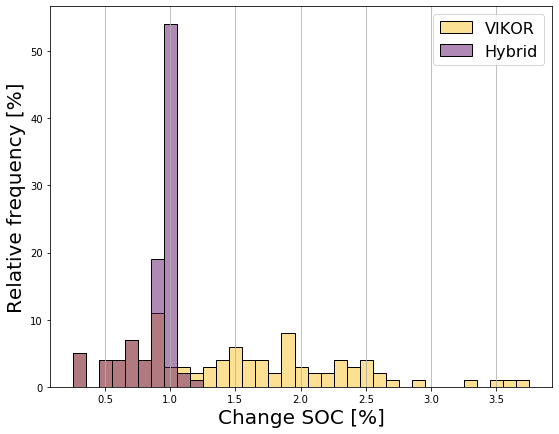

In [20]:
my_stat='percent'
palette = sns.color_palette("inferno")

fig, ax0 = plt.subplots(figsize=(9,7))

line1 = sns.histplot(100*(SOC___solution_found_with_vikor - SOC___soc_optimal)/SOC___soc_optimal,  color=palette[5], alpha=0.5, stat=my_stat, binwidth=0.1, label='VIKOR')   
line2 = sns.histplot(100*(SOC___solution_found_with_hybrid - SOC___soc_optimal)/SOC___soc_optimal, color=palette[1], alpha=0.5, stat=my_stat, binwidth=0.1, label='Hybrid')

plt.xlabel(r'Change SOC [%]', fontsize=20)
plt.ylabel('Relative frequency [%]', fontsize=20)

plt.gca().xaxis.grid(True)
plt.legend(prop={'size': 16}, ncol=1)
plt.show()